# EXAMPLES for roundabout_simplification enhancement
10 Aug 2022

In [1]:
import geopandas as gpd
import momepy as mm
import numpy as np
import pandas as pd
import pygeos
from shapely.geometry import LineString, Point
from shapely.ops import polygonize

/Users/gregoriomaya/mambaforge/envs/test/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<AxesSubplot:>

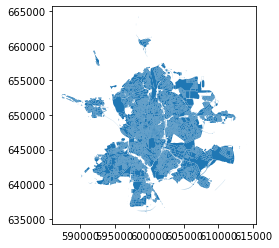

In [2]:
# loading data from file
mad = gpd.read_file(
    "/Users/gregoriomaya/Desktop/GSoc_2022/gsoc2022_network_simpl/data/madrid2062.gpkg"
)
mad.set_index(["u", "v", "key"], inplace=True)


mad_polys = polygonize(mad.geometry)
mad_polys = gpd.GeoDataFrame(geometry=[g for g in mad_polys], crs=mad.crs)
mad_polys.plot()

## loading the needed functions
to replicate what happens in the final **_roundabout_simplification()_**

In [3]:
# for testing purposes only
GPD_10 = True


def _selecting_rabs_from_poly(
    gdf, circom_threshold=0.7, area_threshold=0.85, include_adjacent=True
):
    """
    From a GeoDataFrame of polygons, returns a GDF of polygons that are
    above the Circular Compaactness threshold.

    Return
    ________
    GeoDataFrames : round abouts and adjacent polygons
    """
    # calculate parameters
    gdf = gdf.copy()
    gdf["area"] = gdf.geometry.area
    gdf["circom"] = mm.CircularCompactness(gdf, "area").series

    # selecting round about polygons based on compactness
    rab = gdf[gdf.circom > circom_threshold]
    # exclude those above the area threshold
    area_threshold_val = gdf.area.quantile(area_threshold)
    rab = rab[rab.area < area_threshold_val]

    if include_adjacent is True:
        # calculating some parameters
        bounds = rab.geometry.bounds
        rab = pd.concat([rab, bounds], axis=1)
        rab["deltax"] = rab.maxx - rab.minx
        rab["deltay"] = rab.maxy - rab.miny
        rab["rab_diameter"] = rab[["deltax", "deltay"]].max(axis=1)

        # selecting the adjacent areas that are of smaller than itself
        if GPD_10:
            rab_adj = gpd.sjoin(gdf, rab, predicate="intersects")
        else:
            rab_adj = gpd.sjoin(gdf, rab, op="intersects")
        rab_adj = rab_adj[rab_adj.area_right >= rab_adj.area_left]
        rab_adj.index.name = "index"
        rab_adj["hdist"] = 0

        # adding a hausdorff_distance threshold
        # TODO: (should be a way to verctorize)
        for i, group in rab_adj.groupby("index_right"):
            for g in group.itertuples():
                hdist = g.geometry.hausdorff_distance(rab.loc[i].geometry)
                rab_adj.hdist.loc[g.Index] = hdist

        rab_plus = rab_adj[rab_adj.hdist < rab_adj.rab_diameter]

    else:
        rab["index_right"] = rab.index
        rab_plus = rab

    # only keeping relevant fields
    geom_col = rab_plus.geometry.name
    rab_plus = rab_plus[[geom_col, "index_right"]]

    return rab_plus


def _rabs_center_points(gdf, center_type="centroid"):
    """
    From a selection of roundabouts, returns an aggregated GeoDataFrame
    per round about with extra column with center_type.
    """
    # creating a multipolygon per RAB (as opposed to dissolving) of the entire
    # composition of the RAB
    # temporary DataFrame where geometry is the array of pygeos geometries
    tmp = pd.DataFrame(gdf.copy())  # temporary hack until shapely 2.0 is out
    tmp["geometry"] = tmp.geometry.values.data

    pygeos_geoms = (
        tmp.groupby("index_right")
        .geometry.apply(pygeos.multipolygons)
        .rename("geometry")
    )
    pygeos_geoms = pygeos.make_valid(pygeos_geoms)

    rab_multipolygons = gpd.GeoDataFrame(pygeos_geoms, crs=gdf.crs)
    # make_valid is transforming the multipolygons into geometry collections because of
    # shared edges

    if center_type == "centroid":
        # geometry centroid of the actual circle
        rab_multipolygons["center_pt"] = gdf[
            gdf.index == gdf.index_right
        ].geometry.centroid

    elif center_type == "mean":
        coords, idxs = pygeos.get_coordinates(pygeos_geoms, return_index=True)
        means = {}
        for i in np.unique(idxs):
            tmps = coords[idxs == i]
            target_idx = rab_multipolygons.index[i]
            means[target_idx] = Point(tmps.mean(axis=0))

        rab_multipolygons["center_pt"] = gpd.GeoSeries(means, crs=gdf.crs)

    # centerpoint of minimum_bounding_circle
    # minimun_bounding_circle() should be available in Shapely 2.0. Implementation still
    # pending.
    # current environment has 1.8.2

    return rab_multipolygons

In [111]:
def _coins_filtering_many_incoming(incoming_many, angle_threshold=0):
    """
    Used only for the cases when more than one incoming line touches the
    roundabout.
    """
    coins_filter_result = []
    # For each new connection, evaluate COINS and select the group from which the new
    # line belongs
    # TODO ideally use the groupby object on line_wkt used earlier
    for g, x in incoming_many.groupby("line_wkt"):
        gs = gpd.GeoSeries(pd.concat([x.geometry, x.line]), crs=incoming_many.crs)
        gdf = gpd.GeoDataFrame(geometry=gs)
        gdf.drop_duplicates(inplace=True)

        coins = mm.COINS(gdf, angle_threshold=angle_threshold)
        # coins.stroke_attribute()) # the groups here don't match the stroke_group in
        # .stroke_gdf()
        stroke_gdf = coins.stroke_gdf()
        if GPD_10:
            orig_geom_join = gpd.sjoin(
                stroke_gdf, gpd.GeoDataFrame(geometry=x.line), predicate="covers"
            )
        else:
            orig_geom_join = gpd.sjoin(
                stroke_gdf, gpd.GeoDataFrame(geometry=x.line), op="covers"
            )
        orig_geom = gpd.GeoSeries(
            [orig_geom_join.geometry.iloc[0]], crs=incoming_many.crs
        )
        gs2 = gpd.GeoDataFrame(geometry=orig_geom)

        gs1 = gpd.GeoSeries(x.geometry, crs=incoming_many.crs)
        gs1 = gpd.GeoDataFrame(geometry=gs1)

        # select the the line that's covered by the joined line returned by COINS
        # one could consider using pygeos shared_paths(a, b) # TODO
        if GPD_10:
            result_idx = gpd.sjoin(gs1, gs2, predicate="covered_by").index
        else:
            result_idx = gpd.sjoin(gs1, gs2, op="covered_by").index
        coins_filter_result.extend(result_idx)

    incoming_many_reduced = incoming_many.loc[coins_filter_result]

    return incoming_many_reduced

# replicating BULK_QUERY

In [10]:
selected_rabs = _selecting_rabs_from_poly(mad_polys, include_adjacent=False)

In [11]:
# renaming to use the built-in names of the unpacked function
edges = mad.copy()

rab_idx = [33, 3407]
rab_multipolygons = selected_rabs_center.loc[rab_idx]  # isolating for testing

<AxesSubplot:>

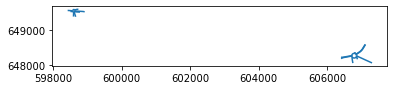

In [34]:
touching = gpd.sjoin(edges, rab_multipolygons, predicate="touches")  # OK
touching.plot()

In [48]:
edges_idx, rabs_idx = rab_multipolygons.sindex.query_bulk(
    edges.geometry, predicate="covered_by"
)
idx_drop = edges.index.take(edges_idx)
idx_drop

MultiIndex([(  20952910,   20952912, 0),
            (  20952910,   20952926, 0),
            (  20952912,   20952914, 0),
            (  20952914, 2424952617, 0),
            (2424952617,   20952942, 0),
            (  20952917, 1298911514, 0),
            (  20952917,   20952942, 0),
            (1298911514, 2424952613, 0),
            (  20952926, 2424952613, 0),
            (  26413139,   26413138, 0),
            (  26413139,   26413141, 0),
            (  26413138,  338727732, 0),
            ( 338727732,   26413152, 0),
            (  26413141,   26413142, 0),
            (  26413142,   26413144, 0),
            (  26413144,   26413145, 0),
            (  26413145,   26413152, 0)],
           names=['u', 'v', 'key'])

<AxesSubplot:>

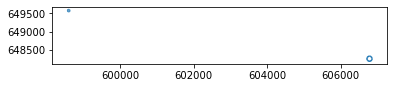

In [49]:
edges.loc[idx_drop].plot()

# replicating the COINS output mismatch 

In [50]:
selected_rabs = _selecting_rabs_from_poly(mad_polys, include_adjacent=False)
selected_rabs_center = _rabs_center_points(selected_rabs)

In [51]:
# renaming to use the built-in names of the unpacked function
edges = mad.copy()

rab_idx = [33, 3407]
rab_multipolygons = selected_rabs_center.loc[rab_idx]  # isolating for testing

angle_threshold = 0  # to use later in COINS

In [52]:
# REPLICANTING WHAT HAPPENS ON _selecting_incoming_lines
# =======================================================

# selecting the lines that are touching but not covered by
if GPD_10:
    touching = gpd.sjoin(edges, rab_multipolygons, predicate="touches")
    edges_idx, rabs_idx = rab_multipolygons.sindex.query_bulk(
        edges.geometry, predicate="covered_by"
    )
else:
    touching = gpd.sjoin(edges, rab_multipolygons, op="touches")
    edges_idx, rabs_idx = rab_multipolygons.sindex.query_bulk(
        edges.geometry, op="covered_by"
    )
idx_drop = edges.index.take(edges_idx)
touching_idx = touching.index
ls = list(set(touching_idx) - set(idx_drop))

incoming = touching.loc[ls]

# figuring out which ends of incoming edges needs to be connected to the center_pt
incoming["first_pt"] = incoming.geometry.apply(lambda x: Point(x.coords[0]))
incoming["dist_fisrt_pt"] = incoming.center_pt.distance(incoming.first_pt)
incoming["last_pt"] = incoming.geometry.apply(lambda x: Point(x.coords[-1]))
incoming["dist_last_pt"] = incoming.center_pt.distance(incoming.last_pt)
lines = []
for i, row in incoming.iterrows():
    if row.dist_fisrt_pt < row.dist_last_pt:
        lines.append(LineString([row.first_pt, row.center_pt]))
    else:
        lines.append(LineString([row.last_pt, row.center_pt]))
incoming["line"] = gpd.GeoSeries(lines, index=incoming.index, crs=edges.crs)

# checking in there are more than one incoming lines arriving to the same point
# which would create several new lines
incoming["line_wkt"] = incoming.line.to_wkt()
grouped_lines = incoming.groupby(["line_wkt"])["line_wkt"]
count_s = grouped_lines.count()

# separating the incoming roads that come on their own to those that come in groups
filter_count_one = pd.DataFrame(count_s[count_s == 1])
filter_count_many = pd.DataFrame(count_s[count_s > 1])
incoming_ones = pd.merge(
    incoming, filter_count_one, left_on="line_wkt", right_index=True, how="inner"
)
incoming_many = pd.merge(
    incoming, filter_count_many, left_on="line_wkt", right_index=True, how="inner"
)

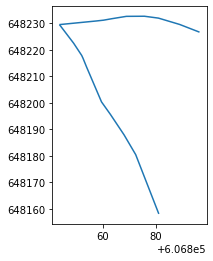

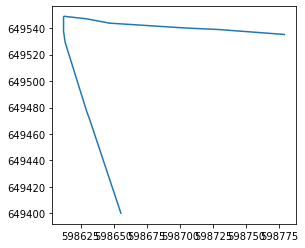

In [53]:
for i in rab_idx:
    incoming_many[incoming_many.index_right == i].plot()

In [113]:
# THIS SHOULD NOW REPLACE THE COINS function
# =======================================================

idx_out_many_incoming = []
# For each new connection, evaluate COINS and select the group from which the new
# line belongs
# TODO ideally use the groupby object on line_wkt used earlier
for g, x in incoming_many.groupby("line_wkt"):
    gs = gpd.GeoSeries(pd.concat([x.geometry, x.line]), crs=incoming_many.crs)
    gdf = gpd.GeoDataFrame(geometry=gs)
    gdf.drop_duplicates(inplace=True)

    coins = mm.COINS(gdf, angle_threshold=angle_threshold)
    group_series = coins.stroke_attribute()
    gdf["coins_group"] = group_series
    # selecting the incoming and its extension
    coins_group_filter = gdf.groupby("coins_group").count() == 1
    f = gdf.coins_group.map(coins_group_filter.geometry)
    idxs_remove = gdf[f].index

    idx_out_many_incoming.extend(idxs_remove)

incoming_many_reduced = incoming_many.drop(idx_out_many_incoming, axis=0)
incoming_many_reduced

,,,line_wkt,osmid,oneway,lanes,name,highway,maxspeed,reversed,length,from,...,geometry,index_right,center_pt,first_pt,dist_fisrt_pt,last_pt,dist_last_pt,line,line_wkt_x,line_wkt_y
u,v,key,,,,,,,,,,,,,,,,,,,,,
20952929,20952942,0,"LINESTRING (606843.605958 648229.44006, 606784...",3996203,True,3,Calle de Suecia,residential,nan,False,81.118,20952929,...,"LINESTRING (606881.022 648158.157, 606872.315 ...",33,POINT (606784.082 648263.239),POINT (606881.022 648158.157),142.967906,POINT (606843.606 648229.440),68.450956,"LINESTRING (606843.606 648229.440, 606784.082 ...","LINESTRING (606843.605958 648229.44006, 606784...",2
26413145,26413364,0,"LINESTRING (598612.131453 649548.934781, 59859...","[335587484, 44737277]",True,4,Calle de Santa Engracia,secondary,50,False,156.464,26413364,...,"LINESTRING (598655.610 649399.637, 598631.904 ...",3407,POINT (598597.016 649572.903),POINT (598655.610 649399.637),182.905228,POINT (598612.131 649548.935),28.336344,"LINESTRING (598612.131 649548.935, 598597.016 ...","LINESTRING (598612.131453 649548.934781, 59859...",2


In [112]:
old_coins = _coins_filtering_many_incoming(incoming_many)
old_coins

,,,line_wkt,osmid,oneway,lanes,name,highway,maxspeed,reversed,length,from,...,geometry,index_right,center_pt,first_pt,dist_fisrt_pt,last_pt,dist_last_pt,line,line_wkt_x,line_wkt_y
u,v,key,,,,,,,,,,,,,,,,,,,,,
26413145,26413364,0,"LINESTRING (598612.131453 649548.934781, 59859...","[335587484, 44737277]",True,4,Calle de Santa Engracia,secondary,50,False,156.464,26413364,...,"LINESTRING (598655.610 649399.637, 598631.904 ...",3407,POINT (598597.016 649572.903),POINT (598655.610 649399.637),182.905228,POINT (598612.131 649548.935),28.336344,"LINESTRING (598612.131 649548.935, 598597.016 ...","LINESTRING (598612.131453 649548.934781, 59859...",2
20952929,20952942,0,"LINESTRING (606843.605958 648229.44006, 606784...",3996203,True,3,Calle de Suecia,residential,nan,False,81.118,20952929,...,"LINESTRING (606881.022 648158.157, 606872.315 ...",33,POINT (606784.082 648263.239),POINT (606881.022 648158.157),142.967906,POINT (606843.606 648229.440),68.450956,"LINESTRING (606843.606 648229.440, 606784.082 ...","LINESTRING (606843.605958 648229.44006, 606784...",2
